Stifler density over k-core

In [1]:
import csv

import networkx as nx
import numpy as np

import seaborn as sns; sns.set()
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import pandas as pd

from collections import Counter
from operator import itemgetter
from os import listdir
from os.path import isfile, isdir, join, exists

In [2]:
plt.rcParams['figure.figsize'] = [10,5]
plt.rcParams['patch.force_edgecolor'] = True
plt.rcParams['font.size'] = 14

In [3]:
mypath = '../../log/'
dirs = [join(mypath, f) for f in listdir(mypath) if isdir(join(mypath,f)) and "Graph" in f]
dirs

['../../log/EmailGraph02',
 '../../log/EmailGraph01',
 '../../log/EmailGraph005',
 '../../log/EmailGraph001']

read all files. skip intestation rows, create an array of raw data, [k-core, stifler-density]

In [4]:
G = nx.Graph()
with open('../../src/datasets/EmailURV/EmailURV.csv', 'r') as file:
    reader = csv.reader(file, delimiter=",")
    for row in reader:
        G.add_edge(int(row[0]), int(row[1]))
N_AGENTS = len(G.nodes())

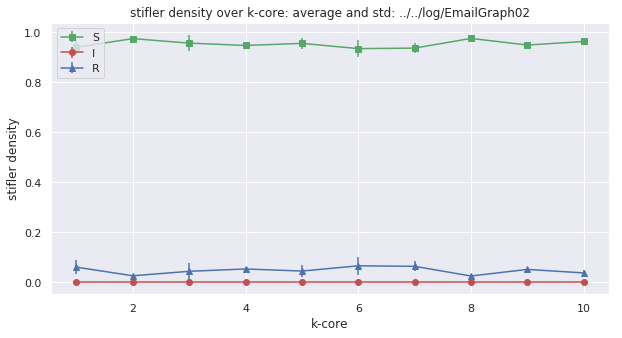

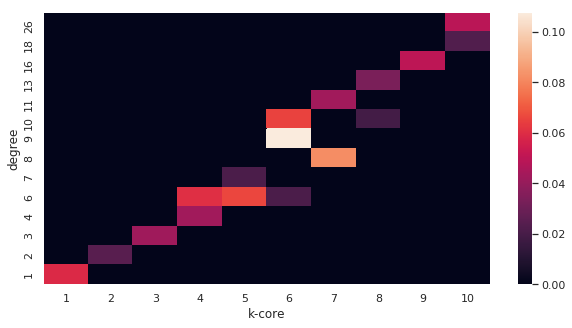

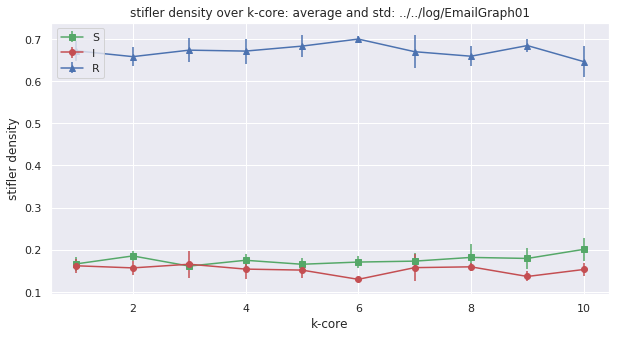

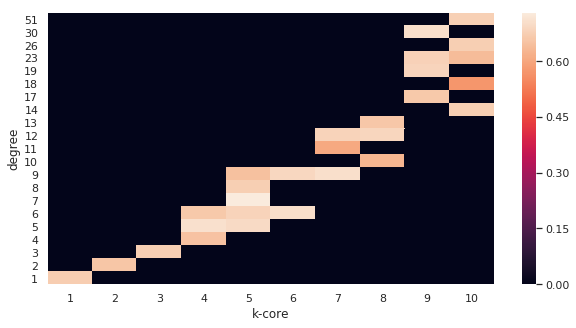

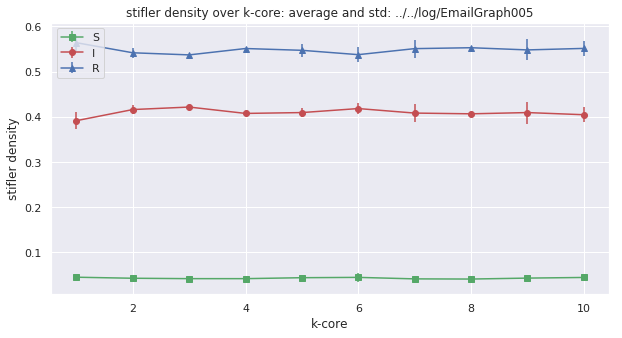

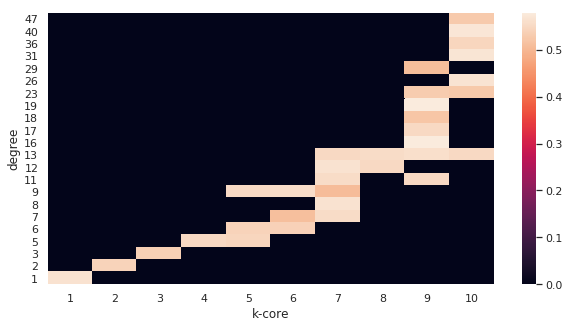

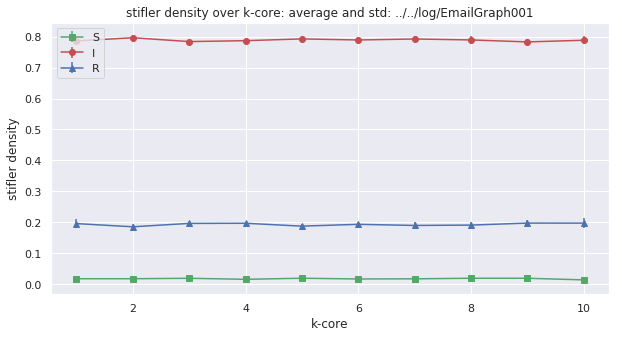

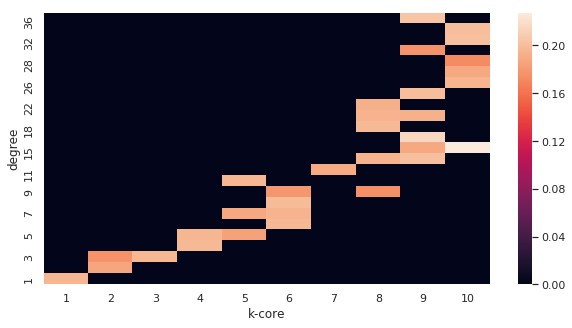

In [5]:
cleanlist_final = []
rawdataframe = pd.DataFrame()

for ddir in dirs:
    kdirs = [f for f in listdir(ddir) if isdir(join(ddir,f))]
    kcores = [join(join(ddir, f),'k_core.csv') for f in kdirs]
    rawdensities = []
    for index, filename in enumerate(kcores):
        s_den = 0
        i_den = 0
        r_den = 0
        k_core = 0
        degree = 0
        number = 0
        with open(filename, 'r') as file:
            reader = csv.reader(file, delimiter=",")
            for row in reader:
                if len(row) < 4:
                    continue
                try:
                    int(row[0])
                except:
                    continue
                if int(row[0]) == 1 and row[3] == 'i':
                    k_core = int(row[2])
                    number = int(row[1]) if int(row[1]) != 0 else 1 ### FIX THIS 
                    ## ERROR ON INDEX 0
                if int(row[0]) != 1:
                    if row[3] == 's':
                        s_den += 1
                    elif row[3] == 'i':
                        i_den += 1
                    elif row[3] == 'r':
                        r_den += 1
                    else:
                        print("unrecognized option", row[3])
        total = s_den +i_den + r_den
        s_den /= total
        i_den /= total
        r_den /= total
        degree = G.degree(number)
        rawdensities.append([k_core, degree, s_den, i_den, r_den])

    # clean spreading that failed
    rawdensities = [el for el in rawdensities if el[2] < 0.99]
    rawdensities = np.array(rawdensities)

    

    # sort by k-core
    rawdensities = np.array(sorted(rawdensities, key=itemgetter(0)))

    k, d, s, i, r = rawdensities.T
    rawdataframe = rawdataframe.append( pd.DataFrame(data={"k-core" : k, 
                            "degree" : d, 
                            "val" : s, 
                            "state" : ['s'] * len(k),
                            "data": [ddir] * len(k)}) )
    rawdataframe = rawdataframe.append( pd.DataFrame(data={"k-core" : k, 
                            "degree" : d, 
                            "val" : i, 
                            "state" : ['i'] * len(k),
                            "data": [ddir] * len(k)}) )
    rawdataframe = rawdataframe.append( pd.DataFrame(data={"k-core" : k, 
                            "degree" : d, 
                            "val" : r, 
                            "state" : ['r'] * len(k),
                            "data": [ddir] * len(k)}) )
    """
    fig = plt.figure()
    ax1 = fig.add_subplot(111)
    
    ax1.plot(k, s, 'sg-', label='S')
    ax1.plot(k, i, 'or-', label='I')
    ax1.plot(k, r, '^b-', label='R')

    plt.legend(loc='upper left')
    plt.title("stifler density over k-core: raw data: "+ddir)
    plt.ylabel("stifler density")
    plt.xlabel("k-core")
    plt.show()
    """
    cleanlist = []
    s_sublist = []
    i_sublist = []
    r_sublist = []

    for i in range(int(max([el[0] for el in np.sort(rawdensities, axis=0)])) + 1):
        if i == 0:
            continue
        s_sublist = [el[2] for el in rawdensities if int(el[0]) == i ]
        i_sublist = [el[3] for el in rawdensities if int(el[0]) == i ]
        r_sublist = [el[4] for el in rawdensities if int(el[0]) == i ]

        cleanlist.append([
            i,
            np.mean(s_sublist),
            np.std(s_sublist),
            np.mean(i_sublist),
            np.std(i_sublist),
            np.mean(r_sublist),
            np.std(r_sublist)
        ])
        s_sublist = []
        i_sublist = []
        r_sublist = []

    fig1 = plt.figure()
    ax2 = fig1.add_subplot(111)

    k_m, s_m, s_s, i_m, i_s, r_m, r_s = np.array([el for el in cleanlist if ~np.isnan(el[1])]).T

    ax2.errorbar(k_m, s_m, yerr=s_s, fmt='gs-', label='S')
    ax2.errorbar(k_m, i_m, yerr=i_s, fmt='ro-', label='I')
    ax2.errorbar(k_m, r_m, yerr=r_s, fmt='b^-', label='R')

    plt.legend(loc='upper left')
    plt.title("stifler density over k-core: average and std: "+ddir)
    plt.ylabel("stifler density")
    plt.xlabel("k-core")

    plt.show()

    cleanlist_final.append(cleanlist)
    
    rawdensities = np.array(sorted(rawdensities, key=itemgetter(1)))
    rawdensities = np.array(sorted(rawdensities, key=itemgetter(0)))
    l = rawdensities.tolist()
    li = [ [int(el[0]), int(el[1]), el[2], el[3], el[4]] for el in l ]


    dict = {}
    for k, d, s, i, r in li:
        dict[(k,d)] = []
    for k, d, s, i, r in li:
        dict[(k,d)].append(r)

    for key in dict:
        dict[key] = np.mean(dict[key])

    kk = []
    dd = []
    rr = []
    for key in dict:
        kk.append(key[0])
        dd.append(key[1])
        rr.append(dict[key])


    df = pd.DataFrame(data={'k-core': kk, 'degree': dd, 'stiflers': rr})
    df =df.pivot("degree", "k-core", "stiflers", ).fillna(0.)
    df = df.iloc[::-1]
    f, ax = plt.subplots()
    sns.heatmap(df, linewidths=0, ax=ax,)#center=df.loc[10,6])
    plt.show()

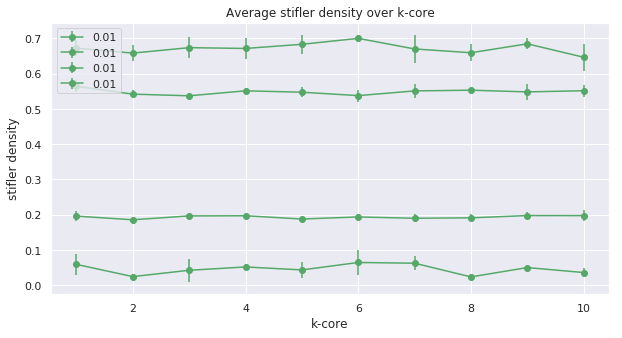

In [6]:
ffig = plt.figure()
ax3 = ffig.add_subplot(111)

for clean in cleanlist_final:
    k_m, s_m, s_s, i_m, i_s, r_m, r_s = np.array([el for el in clean if ~np.isnan(el[1])]).T
    ax3.errorbar(k_m, r_m, yerr=r_s, fmt='go-', label='0.01')

    plt.legend(loc='upper left')
    plt.title("Average stifler density over k-core")
    plt.xlabel("k-core")
    plt.ylabel("stifler density")

    #plt.savefig('/home/nik/Documents/masterthesis/img/pdf/stiflerdensityoverkcore.pdf')

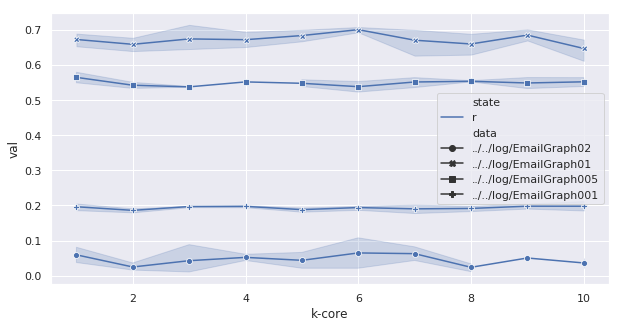

In [7]:
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
fmri = sns.load_dataset("fmri")
ax = sns.lineplot(x="k-core", y="val", hue="state", style="data",
                  markers=True, dashes=False,
                  data=rawdataframe.loc[rawdataframe['state'] == 'r']
)